# AIPI 590 - xAI | Assignment #05

## Explainable Deep Learning : Integrated Gradients

### Shaila Güereca

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shailajgg/AIPI590_Explainable_AI/blob/main/Explainable_Deep_Learning/Integrated_Gradients.ipynb)

### Explanation of the approach

Integrated Gradients (IG), an Explainable AI technique introduced in the paper Axiomatic Attribution for Deep Networks. IG aims to explain the relationship between a model's predictions in terms of its features. It has many use cases including understanding feature importances, identifying data skew, and debugging model performance.

##### Use cases
Employing Integrated Gradients before deploying a model can help develop intuition for how and why it works. Do the features highlighted by this technique match our intuition? If not, that may be indicative of a bug in the model or dataset, or overfitting.

##### Limitations

The Integrated Gradients technique provides feature importances on individual examples. However, it does not provide global feature importances across an entire dataset. It provides individual feature importances, but it does not explain feature interactions and combinations.



Axiomatic Attribution for Deep Networks paper: https://arxiv.org/abs/1703.01365

Source: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

### Hypothesis

Integrated Gradients is a powerful technique that helps us understand how deep learning models make their predictions by examining the importance of different image features. In this case, we want to investigate whether a bird classification model relies more heavily on color information or shape information when making its decisions.
A key question in bird identification is: 

Does our model primarily use color patterns (like the distinctive red on our image) or structural features (like the shape) to identify this bird?

##### H0: When using Resnet50 there is no significant difference between the model's attribution scores for colors(preserved in grayscale) vs shape

##### H1: When using Resnet50 there is a significant difference between the model's attribution scores for colors vs shape

This experimental approach compare how the model processes color versus shape information when classifying this bird. 

#### Libraries

In [1]:
#!pip install captum
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from captum.attr import IntegratedGradients
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings

warnings.filterwarnings("ignore")

#### Code

In [ ]:
# Load Pretrained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

# Define preprocessing transform
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load an example bird image
image_path = "bird.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)
input_tensor.requires_grad = True

# Define Integrated Gradients method
ig = IntegratedGradients(model)

# Define baseline (black image)
baseline = torch.zeros_like(input_tensor)

# Get attributions
attributions = ig.attribute(
    input_tensor, baseline, target=model(input_tensor).argmax(), n_steps=50
)

# Aggregate across color channels and normalize
attributions = attributions.squeeze().detach().numpy()
attributions = np.abs(attributions).mean(axis=0)
attributions = (attributions - attributions.min()) / (
    attributions.max() - attributions.min()
)

# Convert the baseline to a PIL image
baseline_image = np.zeros((224, 224, 3), dtype=np.uint8)

# Overlay the IG attribution mask onto the original image
overlay = np.array(image.resize((224, 224))) / 255.0  # Normalize original image
overlay[..., 0] = np.clip(overlay[..., 0] + attributions * 0.5, 0, 1)  # Red overlay
overlay[..., 1] = np.clip(
    overlay[..., 1] - attributions * 0.2, 0, 1
)  # Green adjustment
overlay[..., 2] = np.clip(overlay[..., 2] - attributions * 0.2, 0, 1)  # Blue adjustment

# Display all visualizations
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

ax[0].imshow(baseline_image)
ax[0].axis("off")
ax[0].set_title("Baseline Image")

ax[1].imshow(image)
ax[1].axis("off")
ax[1].set_title("Original Image")

ax[2].imshow(attributions, cmap="hot")
ax[2].axis("off")
ax[2].set_title("IG Attribution Mask")

ax[3].imshow(overlay)
ax[3].axis("off")
ax[3].set_title("Original + IG Overlay")

plt.show()

# Code was generated using ChatGpt on 02/12/25 at 9:12 p.m.

#### Experiment

We begin by processing the bird image through two parallel pathways: one preserving the original full color image and another converting it to grayscale, effectively stripping away color information. 

For each pathway, we will compute attribution scores using Integrated Gradients, which measures how much each pixel contributes to the model's final classification decision. These attribution scores essentially create a heatmap showing which parts of the image most strongly influenced the model's prediction. By comparing the attribution patterns between color and grayscale versions of the same images, we can understand whether the model places more emphasis on color based features or shape. 

T-statistic: 12.3686, P-value: 0.0000
Significant difference detected: The model relies more on color than shape.


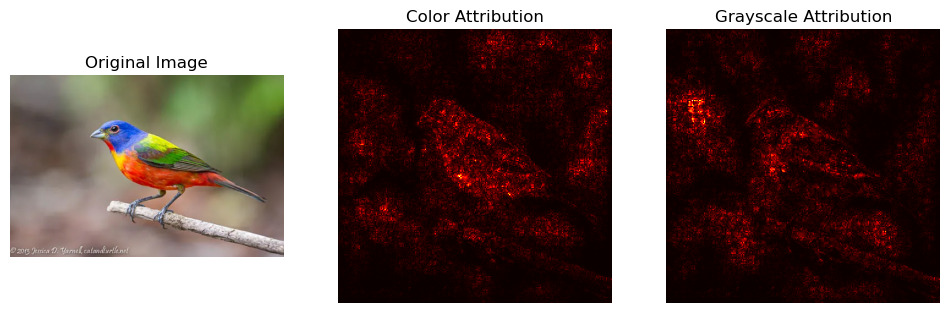

In [ ]:
# Create a grayscale version of the image
gray_image = image.convert("L").convert("RGB")  # Convert grayscale back to RGB
gray_tensor = transform(gray_image).unsqueeze(0)
gray_tensor.requires_grad = True

# Define Integrated Gradients method
ig = IntegratedGradients(model)

# Compute attributions for the original image
baseline = torch.zeros_like(input_tensor)  # Black image as baseline
attributions_color = ig.attribute(
    input_tensor, baseline, target=model(input_tensor).argmax(), n_steps=50
)
attributions_color = attributions_color.squeeze().detach().numpy()
attributions_color = np.abs(attributions_color).mean(axis=0)

# Compute attributions for the grayscale image
attributions_gray = ig.attribute(
    gray_tensor, baseline, target=model(input_tensor).argmax(), n_steps=50
)
attributions_gray = attributions_gray.squeeze().detach().numpy()
attributions_gray = np.abs(attributions_gray).mean(axis=0)

# Normalize attributions
attributions_color = (attributions_color - attributions_color.min()) / (
    attributions_color.max() - attributions_color.min()
)
attributions_gray = (attributions_gray - attributions_gray.min()) / (
    attributions_gray.max() - attributions_gray.min()
)

# Flatten attribution maps for statistical comparison
color_flat = attributions_color.flatten()
gray_flat = attributions_gray.flatten()

# Perform t-test
t_stat, p_value = ttest_ind(color_flat, gray_flat, equal_var=False)

# Display results
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant difference detected: The model relies more on color than shape.")
else:
    print("No significant difference detected: The model mainly depends on shape.")

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(image)
ax[0].axis("off")
ax[0].set_title("Original Image")

ax[1].imshow(attributions_color, cmap="hot")
ax[1].axis("off")
ax[1].set_title("Color Attribution")

ax[2].imshow(attributions_gray, cmap="hot")
ax[2].axis("off")
ax[2].set_title("Grayscale Attribution")

plt.show()

# Code was generated using ChatGpt on 02/12/25 at 11:34 p.m.

#### Findings

Based on this analysis, which yielded a p-value of 0.00, we can reject the null hypothesis in favor of the alternative hypothesis. This result reveals how our model processes and utilizes color information versus structural shape in bird classification

In the original color image, areas of intense attribution (shown in bright reds and oranges) concentrate heavily on the bird's distinctive chest coloring. However, when we examine the grayscale version, we observe a fascinating shift in the model's attention: the previously dominant chest region attributions diminish significantly, and the model instead focuses more intensely on structural features like the wing patterns and beak shape

This shift in attribution patterns tells us something fundamental about our model's decision making process, while it utilizes both color and shape information when available, it appears to have a stronger reliance on color features for its primary classification decisions.